# Use Case: CNC Machine Tool Wear Monitoring

## Scenario

A precision machining facility operates CNC milling and turning centers. Cutting tool wear directly impacts:
- **Part quality** (surface finish, dimensional accuracy)
- **Machine utilization** (unplanned tool changes)
- **Cost** (premature replacement, scrap parts)

### Monitoring Goals
1. **Predict tool wear** in real-time
2. **Estimate remaining tool life** (RTL)
3. **Detect tool breakage** immediately
4. **Optimize tool change intervals**

### Sensors & Data
| Sensor | Description | Sample Rate |
|--------|-------------|-------------|
| Spindle current | Motor load indication | 100 Hz |
| Cutting force | Dynamometer (Fx, Fy, Fz) | 1 kHz |
| Vibration | Accelerometer on spindle | 10 kHz |
| Acoustic emission | Ultrasonic sensor | 1 MHz (processed) |
| Temperature | Tool/workpiece IR | 10 Hz |

### Tool Wear Mechanisms
- **Flank wear (VB)**: Primary wear on clearance face
- **Crater wear**: Wear on rake face
- **Chipping**: Edge breakage
- **Built-up edge (BUE)**: Material adhesion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import joblib

np.random.seed(42)

# Output directories
DATA_DIR = '../data/usecase_cnc'
MODEL_DIR = '../models/usecase_cnc'
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


## 1. CNC Machining Simulation

In [2]:
class CNCToolWearSimulator:
    """
    Simulates CNC machining with progressive tool wear.
    
    Based on Taylor's tool life equation and real machining data patterns.
    """
    
    def __init__(self,
                 tool_type='carbide_endmill',
                 workpiece='steel_1045',
                 spindle_speed=3000,     # RPM
                 feed_rate=200,          # mm/min
                 depth_of_cut=2.0):      # mm
        
        self.tool_type = tool_type
        self.workpiece = workpiece
        self.spindle_speed = spindle_speed
        self.feed_rate = feed_rate
        self.depth_of_cut = depth_of_cut
        
        # Tool parameters
        self.tool_diameter = 10  # mm
        self.num_flutes = 4
        
        # Cutting speed
        self.cutting_speed = np.pi * self.tool_diameter * spindle_speed / 1000  # m/min
        
        # Taylor's equation: V * T^n = C
        # For carbide in steel: n ≈ 0.25, C ≈ 200
        self.taylor_n = 0.25
        self.taylor_C = 200
        
        # Calculate theoretical tool life (minutes)
        self.theoretical_life = (self.taylor_C / self.cutting_speed) ** (1 / self.taylor_n)
        
        # Wear threshold (VB in mm)
        self.wear_limit = 0.3  # mm (typical for finishing)
        self.wear_warning = 0.2  # mm
        
        print(f"CNC Simulator: {tool_type} on {workpiece}")
        print(f"  Cutting speed: {self.cutting_speed:.1f} m/min")
        print(f"  Theoretical tool life: {self.theoretical_life:.0f} min")
    
    def generate_tool_life(self, actual_life_minutes=None, samples_per_minute=60):
        """
        Generate complete tool life data from new to worn.
        """
        if actual_life_minutes is None:
            # Random variation around theoretical life
            actual_life_minutes = self.theoretical_life * np.random.uniform(0.7, 1.3)
        
        n_samples = int(actual_life_minutes * samples_per_minute)
        t = np.linspace(0, actual_life_minutes, n_samples)  # Time in minutes
        
        # Wear progression (S-curve: slow-fast-slow)
        wear = self._wear_curve(t, actual_life_minutes)
        
        # Generate sensor signals based on wear
        data = self._generate_signals(t, wear)
        data['time_min'] = t
        data['wear_vb'] = wear
        data['tool_life_remaining'] = actual_life_minutes - t
        data['tool_life_pct'] = (actual_life_minutes - t) / actual_life_minutes * 100
        
        return pd.DataFrame(data)
    
    def _wear_curve(self, t, total_life):
        """
        Generate realistic wear progression.
        
        Three phases:
        1. Initial wear (break-in): rapid increase
        2. Steady wear: linear progression
        3. Accelerated wear: exponential near end
        """
        normalized_t = t / total_life
        wear = np.zeros_like(t)
        
        # Phase 1: Initial wear (0-10%)
        mask1 = normalized_t <= 0.1
        wear[mask1] = 0.05 * (1 - np.exp(-10 * normalized_t[mask1]))
        
        # Phase 2: Steady wear (10-80%)
        mask2 = (normalized_t > 0.1) & (normalized_t <= 0.8)
        wear[mask2] = 0.05 + 0.15 * (normalized_t[mask2] - 0.1) / 0.7
        
        # Phase 3: Accelerated wear (80-100%)
        mask3 = normalized_t > 0.8
        wear[mask3] = 0.20 + 0.10 * np.exp(3 * (normalized_t[mask3] - 0.8)) - 0.10
        
        # Scale to wear limit
        wear = wear * self.wear_limit / wear[-1] if wear[-1] > 0 else wear
        
        # Add noise
        wear += np.random.normal(0, 0.005, len(wear))
        wear = np.clip(wear, 0, self.wear_limit * 1.2)
        
        return wear
    
    def _generate_signals(self, t, wear):
        """
        Generate sensor signals based on wear level.
        """
        n = len(t)
        wear_factor = wear / self.wear_limit  # 0-1 normalized
        
        # Cutting forces (increase with wear)
        base_force_x = 500  # N (feed direction)
        base_force_y = 300  # N (cross-feed)
        base_force_z = 200  # N (axial)
        
        force_x = base_force_x * (1 + 0.8 * wear_factor) + np.random.normal(0, 20, n)
        force_y = base_force_y * (1 + 0.6 * wear_factor) + np.random.normal(0, 15, n)
        force_z = base_force_z * (1 + 0.5 * wear_factor) + np.random.normal(0, 10, n)
        
        # Resultant force
        force_resultant = np.sqrt(force_x**2 + force_y**2 + force_z**2)
        
        # Spindle current (proportional to power)
        base_current = 8  # Amps
        spindle_current = base_current * (1 + 0.5 * wear_factor)
        spindle_current += np.random.normal(0, 0.2, n)
        
        # Vibration (increases significantly with wear)
        base_vibration = 0.5  # g RMS
        vibration = base_vibration * (1 + 3 * wear_factor ** 1.5)
        vibration += np.random.normal(0, 0.05, n)
        # Add chatter component at high wear
        chatter_freq = self.spindle_speed / 60 * self.num_flutes  # Tooth passing frequency
        chatter_amp = 0.3 * wear_factor ** 2
        vibration += chatter_amp * np.abs(np.sin(2 * np.pi * chatter_freq * t / 60))
        
        # Acoustic emission (high frequency)
        base_ae = 0.2  # Normalized
        ae_rms = base_ae * (1 + 4 * wear_factor ** 2)
        ae_rms += np.random.normal(0, 0.03, n)
        
        # Temperature (cutting zone)
        base_temp = 150  # °C
        temperature = base_temp * (1 + 0.4 * wear_factor)
        temperature += np.random.normal(0, 5, n)
        
        # Surface roughness (estimated from signals)
        base_roughness = 1.6  # Ra in μm
        surface_roughness = base_roughness * (1 + 2 * wear_factor ** 1.5)
        surface_roughness += np.random.normal(0, 0.1, n)
        
        # Power consumption
        power = spindle_current * 400 * 0.85 / 1000  # kW approx
        
        return {
            'force_x': force_x,
            'force_y': force_y,
            'force_z': force_z,
            'force_resultant': force_resultant,
            'spindle_current': spindle_current,
            'vibration_rms': vibration,
            'ae_rms': ae_rms,
            'temperature': temperature,
            'surface_roughness': surface_roughness,
            'power_kw': power
        }
    
    def generate_tool_breakage(self, break_time_pct=0.7):
        """
        Generate data for tool that breaks prematurely.
        """
        # Normal operation until breakage
        break_time = self.theoretical_life * break_time_pct
        df = self.generate_tool_life(actual_life_minutes=break_time * 1.1)
        
        # Find break point
        break_idx = int(len(df) * 0.9)
        
        # Add breakage event
        df.loc[break_idx:, 'force_resultant'] *= 3  # Sudden spike
        df.loc[break_idx:, 'vibration_rms'] *= 5
        df.loc[break_idx:, 'ae_rms'] *= 4
        df.loc[break_idx:, 'spindle_current'] *= 1.5
        
        # Mark breakage
        df['is_broken'] = 0
        df.loc[break_idx:, 'is_broken'] = 1
        
        return df


# Create simulator
cnc = CNCToolWearSimulator(
    spindle_speed=3000,
    feed_rate=200,
    depth_of_cut=2.0
)

CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 94.2 m/min
  Theoretical tool life: 20 min


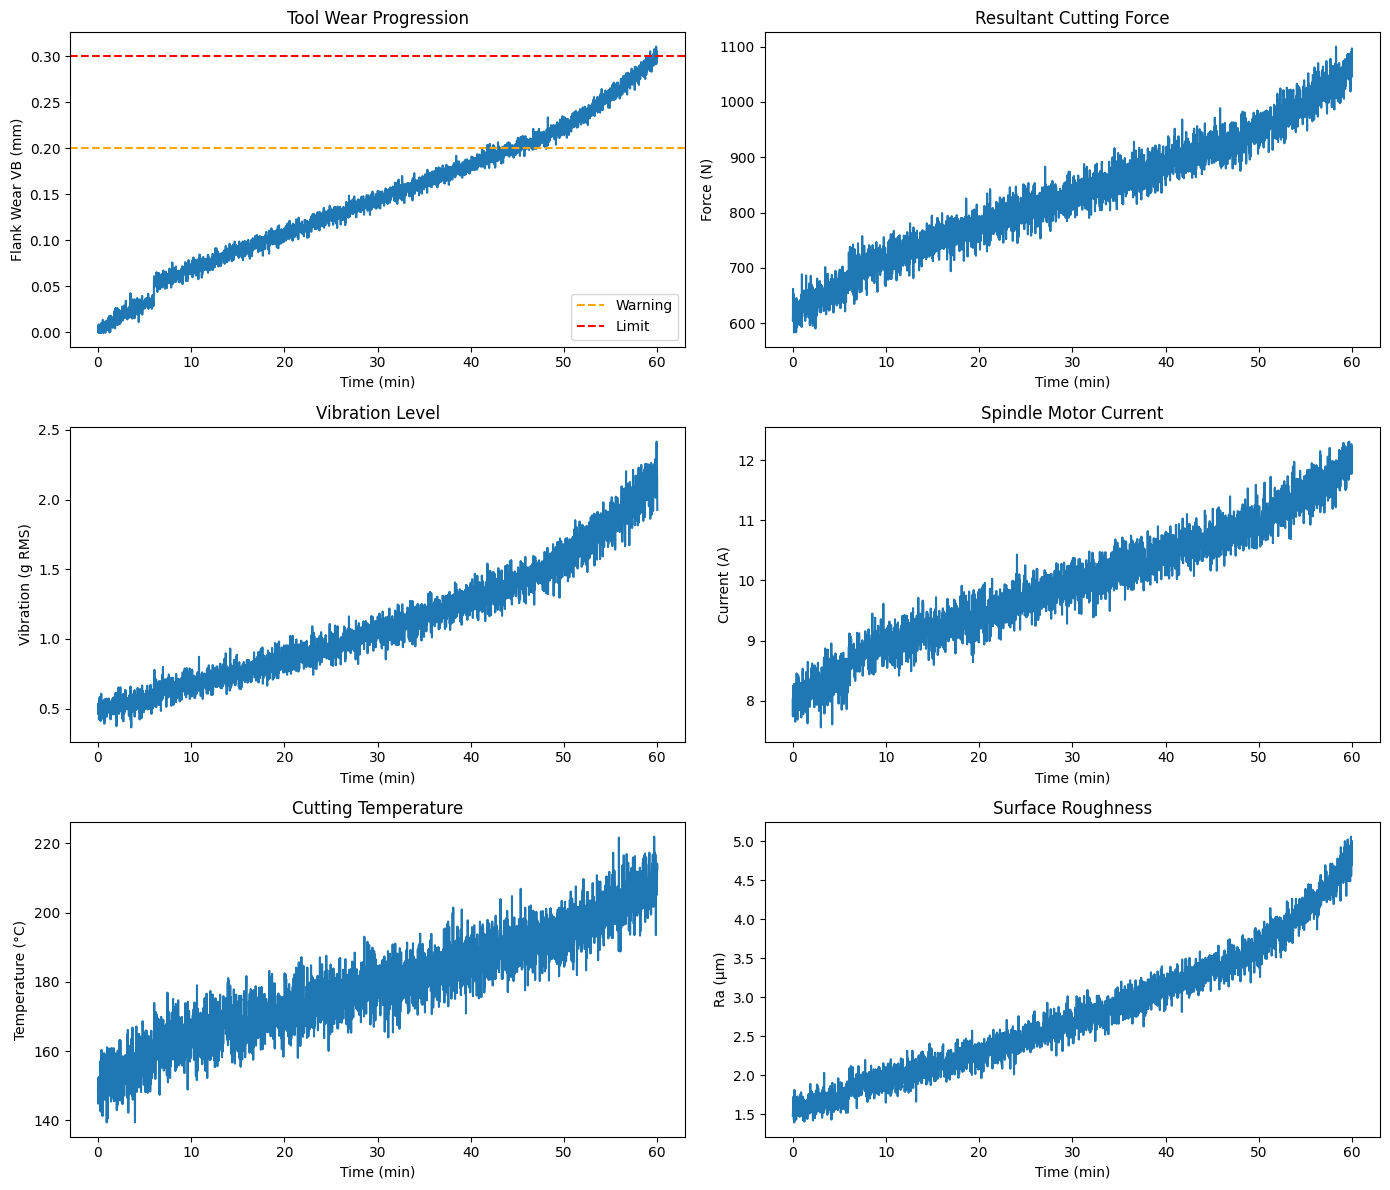

In [3]:
# Generate and visualize single tool life
df_single = cnc.generate_tool_life(actual_life_minutes=60)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Wear progression
axes[0, 0].plot(df_single['time_min'], df_single['wear_vb'])
axes[0, 0].axhline(cnc.wear_warning, color='orange', linestyle='--', label='Warning')
axes[0, 0].axhline(cnc.wear_limit, color='red', linestyle='--', label='Limit')
axes[0, 0].set_xlabel('Time (min)')
axes[0, 0].set_ylabel('Flank Wear VB (mm)')
axes[0, 0].set_title('Tool Wear Progression')
axes[0, 0].legend()

# Cutting force
axes[0, 1].plot(df_single['time_min'], df_single['force_resultant'])
axes[0, 1].set_xlabel('Time (min)')
axes[0, 1].set_ylabel('Force (N)')
axes[0, 1].set_title('Resultant Cutting Force')

# Vibration
axes[1, 0].plot(df_single['time_min'], df_single['vibration_rms'])
axes[1, 0].set_xlabel('Time (min)')
axes[1, 0].set_ylabel('Vibration (g RMS)')
axes[1, 0].set_title('Vibration Level')

# Spindle current
axes[1, 1].plot(df_single['time_min'], df_single['spindle_current'])
axes[1, 1].set_xlabel('Time (min)')
axes[1, 1].set_ylabel('Current (A)')
axes[1, 1].set_title('Spindle Motor Current')

# Temperature
axes[2, 0].plot(df_single['time_min'], df_single['temperature'])
axes[2, 0].set_xlabel('Time (min)')
axes[2, 0].set_ylabel('Temperature (°C)')
axes[2, 0].set_title('Cutting Temperature')

# Surface roughness
axes[2, 1].plot(df_single['time_min'], df_single['surface_roughness'])
axes[2, 1].set_xlabel('Time (min)')
axes[2, 1].set_ylabel('Ra (μm)')
axes[2, 1].set_title('Surface Roughness')

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/tool_wear_progression.png', dpi=150)
plt.show()

## 2. Generate Training Dataset

In [4]:
def generate_cnc_dataset(n_tools=50):
    """
    Generate dataset from multiple tools.
    """
    all_data = []
    
    print(f"Generating data for {n_tools} tools...")
    
    for i in range(n_tools):
        # Variable cutting conditions
        spindle_speed = np.random.uniform(2500, 4000)
        feed_rate = np.random.uniform(150, 300)
        depth_of_cut = np.random.uniform(1.0, 3.0)
        
        cnc = CNCToolWearSimulator(
            spindle_speed=spindle_speed,
            feed_rate=feed_rate,
            depth_of_cut=depth_of_cut
        )
        
        # Random tool life
        life_variation = np.random.uniform(0.5, 1.2)
        actual_life = cnc.theoretical_life * life_variation
        actual_life = np.clip(actual_life, 20, 120)  # 20-120 minutes
        
        df = cnc.generate_tool_life(actual_life_minutes=actual_life, samples_per_minute=30)
        df['tool_id'] = i
        df['spindle_speed'] = spindle_speed
        df['feed_rate'] = feed_rate
        df['depth_of_cut'] = depth_of_cut
        
        all_data.append(df)
        
        if (i + 1) % 10 == 0:
            print(f"  {i + 1}/{n_tools}")
    
    return pd.concat(all_data, ignore_index=True)


# Generate dataset
df_cnc = generate_cnc_dataset(n_tools=40)

print(f"\nDataset: {len(df_cnc)} samples")
print(f"Tools: {df_cnc['tool_id'].nunique()}")
print(f"Wear range: {df_cnc['wear_vb'].min():.3f} - {df_cnc['wear_vb'].max():.3f} mm")

Generating data for 40 tools...
CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 89.8 m/min
  Theoretical tool life: 25 min
CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 102.3 m/min
  Theoretical tool life: 15 min
CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 123.7 m/min
  Theoretical tool life: 7 min
CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 117.1 m/min
  Theoretical tool life: 8 min
CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 123.1 m/min
  Theoretical tool life: 7 min
CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 107.6 m/min
  Theoretical tool life: 12 min
CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 125.3 m/min
  Theoretical tool life: 6 min
CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 122.7 m/min
  Theoretical tool life: 7 min
CNC Simulator: carbide_endmill on steel_1045
  Cutting speed: 105.7 m/min
  Theoretical tool life: 13 min
CNC Simulator: carbi

## 3. Feature Engineering

In [5]:
def extract_cnc_features(df):
    """
    Extract derived features for tool wear prediction.
    """
    features = df.copy()
    
    # Force ratios
    features['force_xy_ratio'] = features['force_x'] / (features['force_y'] + 1)
    features['force_z_ratio'] = features['force_z'] / (features['force_resultant'] + 1)
    
    # Specific cutting energy (force per unit MRR)
    mrr = features['feed_rate'] * features['depth_of_cut'] * 10  # mm³/min approx
    features['specific_energy'] = features['force_resultant'] / (mrr + 1)
    
    # Power-force ratio (efficiency indicator)
    features['power_force_ratio'] = features['power_kw'] * 1000 / (features['force_resultant'] + 1)
    
    # Vibration to force ratio
    features['vib_force_ratio'] = features['vibration_rms'] / (features['force_resultant'] / 1000 + 0.1)
    
    # AE to vibration ratio
    features['ae_vib_ratio'] = features['ae_rms'] / (features['vibration_rms'] + 0.1)
    
    # Temperature rise rate (would need time-series processing in practice)
    features['temp_normalized'] = features['temperature'] / 200  # Normalized to max expected
    
    # Cutting speed (derived)
    features['cutting_speed'] = np.pi * 10 * features['spindle_speed'] / 1000  # m/min
    
    # Wear state classification
    # Clip values to valid range before binning
    wear_clipped = features['wear_vb'].clip(0, 1.0)
    features['wear_state'] = pd.cut(
        wear_clipped,
        bins=[-0.001, 0.1, 0.2, 0.3, 1.001],
        labels=['new', 'good', 'worn', 'critical']
    ).astype(str)
    
    return features


# Apply feature engineering
df_features = extract_cnc_features(df_cnc)

print("Feature engineering complete")
print(f"Total features: {len(df_features.columns)}")
print("\nWear state distribution:")
print(df_features['wear_state'].value_counts())

Feature engineering complete
Total features: 27

Wear state distribution:
wear_state
good        10787
new          7516
worn         6150
critical       87
Name: count, dtype: int64


## 4. Train Wear Prediction Model (Regression)

In [6]:
# Features for wear prediction
feature_cols = [
    'force_x', 'force_y', 'force_z', 'force_resultant',
    'spindle_current', 'vibration_rms', 'ae_rms', 'temperature',
    'power_kw', 'spindle_speed', 'feed_rate', 'depth_of_cut',
    'force_xy_ratio', 'force_z_ratio', 'specific_energy',
    'power_force_ratio', 'vib_force_ratio', 'ae_vib_ratio'
]

X = df_features[feature_cols].values
y_wear = df_features['wear_vb'].values
y_rtl = df_features['tool_life_remaining'].values

# Split by tool
tool_ids = df_features['tool_id'].unique()
train_tools = tool_ids[:int(len(tool_ids) * 0.8)]
test_tools = tool_ids[int(len(tool_ids) * 0.8):]

train_mask = df_features['tool_id'].isin(train_tools)
test_mask = df_features['tool_id'].isin(test_tools)

X_train, X_test = X[train_mask], X[test_mask]
y_wear_train, y_wear_test = y_wear[train_mask], y_wear[test_mask]
y_rtl_train, y_rtl_test = y_rtl[train_mask], y_rtl[test_mask]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)} samples ({len(train_tools)} tools)")
print(f"Test: {len(X_test)} samples ({len(test_tools)} tools)")

Training: 19416 samples (32 tools)
Test: 5124 samples (8 tools)


In [7]:
# Train Random Forest for wear prediction
rf_wear = RandomForestRegressor(
    n_estimators=150,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_wear.fit(X_train_scaled, y_wear_train)
y_wear_pred = rf_wear.predict(X_test_scaled)

# Metrics
rmse = np.sqrt(mean_squared_error(y_wear_test, y_wear_pred))
mae = mean_absolute_error(y_wear_test, y_wear_pred)
r2 = r2_score(y_wear_test, y_wear_pred)

print("Wear Prediction Results:")
print(f"  RMSE: {rmse:.4f} mm")
print(f"  MAE: {mae:.4f} mm")
print(f"  R²: {r2:.4f}")

Wear Prediction Results:
  RMSE: 0.0061 mm
  MAE: 0.0048 mm
  R²: 0.9935


In [8]:
# Train model for Remaining Tool Life prediction
rf_rtl = RandomForestRegressor(
    n_estimators=150,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Cap RTL at max value for better predictions
max_rtl = 60  # minutes
y_rtl_train_capped = np.minimum(y_rtl_train, max_rtl)
y_rtl_test_capped = np.minimum(y_rtl_test, max_rtl)

rf_rtl.fit(X_train_scaled, y_rtl_train_capped)
y_rtl_pred = rf_rtl.predict(X_test_scaled)

# Metrics
rmse_rtl = np.sqrt(mean_squared_error(y_rtl_test_capped, y_rtl_pred))
mae_rtl = mean_absolute_error(y_rtl_test_capped, y_rtl_pred)
r2_rtl = r2_score(y_rtl_test_capped, y_rtl_pred)

print("Remaining Tool Life Prediction:")
print(f"  RMSE: {rmse_rtl:.2f} min")
print(f"  MAE: {mae_rtl:.2f} min")
print(f"  R²: {r2_rtl:.4f}")

Remaining Tool Life Prediction:
  RMSE: 1.68 min
  MAE: 0.95 min
  R²: 0.9383


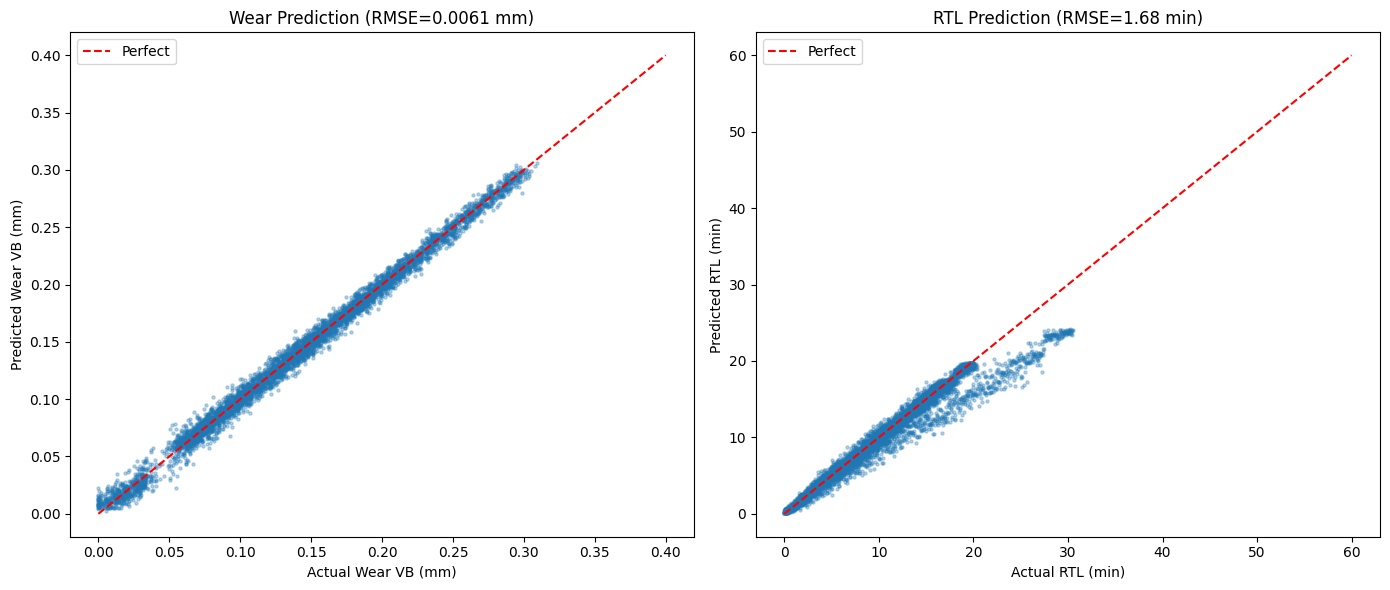

In [9]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wear prediction
axes[0].scatter(y_wear_test, y_wear_pred, alpha=0.3, s=5)
axes[0].plot([0, 0.4], [0, 0.4], 'r--', label='Perfect')
axes[0].set_xlabel('Actual Wear VB (mm)')
axes[0].set_ylabel('Predicted Wear VB (mm)')
axes[0].set_title(f'Wear Prediction (RMSE={rmse:.4f} mm)')
axes[0].legend()

# RTL prediction
axes[1].scatter(y_rtl_test_capped, y_rtl_pred, alpha=0.3, s=5)
axes[1].plot([0, max_rtl], [0, max_rtl], 'r--', label='Perfect')
axes[1].set_xlabel('Actual RTL (min)')
axes[1].set_ylabel('Predicted RTL (min)')
axes[1].set_title(f'RTL Prediction (RMSE={rmse_rtl:.2f} min)')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/wear_prediction_results.png', dpi=150)
plt.show()

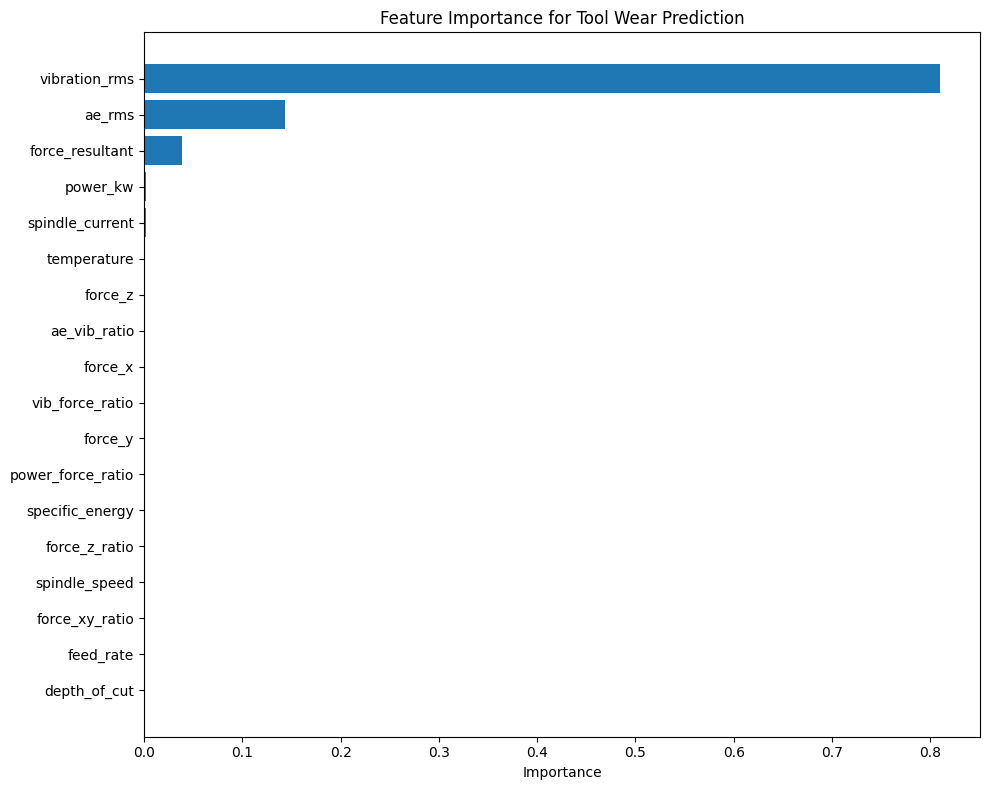

In [10]:
# Feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_wear.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Tool Wear Prediction')
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/wear_feature_importance.png', dpi=150)
plt.show()

## 5. Wear State Classification

In [11]:
# Classification: new/good/worn/critical
y_state = df_features['wear_state'].values

le = LabelEncoder()
y_state_encoded = le.fit_transform(y_state)

y_state_train = y_state_encoded[train_mask]
y_state_test = y_state_encoded[test_mask]

# Train classifier
gb_class = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42
)

gb_class.fit(X_train_scaled, y_state_train)
y_state_pred = gb_class.predict(X_test_scaled)

print("Wear State Classification:")
print(classification_report(y_state_test, y_state_pred, target_names=le.classes_))

Wear State Classification:
              precision    recall  f1-score   support

    critical       0.15      0.14      0.15        14
        good       0.94      0.96      0.95      2238
         new       0.97      0.95      0.96      1581
        worn       0.96      0.95      0.96      1291

    accuracy                           0.95      5124
   macro avg       0.76      0.75      0.75      5124
weighted avg       0.95      0.95      0.95      5124



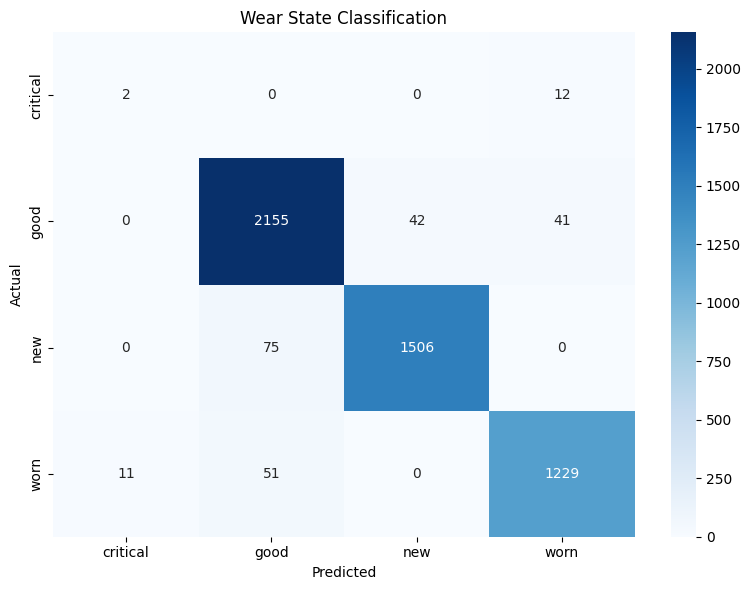

In [12]:
# Confusion matrix
cm = confusion_matrix(y_state_test, y_state_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Wear State Classification')
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/wear_state_confusion.png', dpi=150)
plt.show()

## 6. Save Models and Data

In [13]:
import json

# Save models
joblib.dump(rf_wear, f'{MODEL_DIR}/cnc_wear_rf.joblib')
joblib.dump(rf_rtl, f'{MODEL_DIR}/cnc_rtl_rf.joblib')
joblib.dump(gb_class, f'{MODEL_DIR}/cnc_state_gb.joblib')
joblib.dump(scaler, f'{MODEL_DIR}/cnc_scaler.joblib')
joblib.dump(le, f'{MODEL_DIR}/cnc_label_encoder.joblib')

# Save metadata
metadata = {
    'features': feature_cols,
    'wear_states': list(le.classes_),
    'models': {
        'wear_prediction': {
            'file': 'cnc_wear_rf.joblib',
            'rmse': float(rmse),
            'mae': float(mae),
            'output': 'wear_vb in mm'
        },
        'rtl_prediction': {
            'file': 'cnc_rtl_rf.joblib',
            'rmse': float(rmse_rtl),
            'mae': float(mae_rtl),
            'output': 'remaining_life in minutes',
            'max_rtl': max_rtl
        },
        'state_classification': {
            'file': 'cnc_state_gb.joblib',
            'classes': list(le.classes_)
        }
    },
    'thresholds': {
        'wear_warning': 0.2,
        'wear_limit': 0.3,
        'rtl_warning': 10,  # minutes
        'rtl_critical': 5   # minutes
    }
}

with open(f'{MODEL_DIR}/cnc_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Save dataset
df_features.to_csv(f'{DATA_DIR}/cnc_tool_wear_dataset.csv', index=False)

print("Saved:")
for f in os.listdir(MODEL_DIR):
    print(f"  - {MODEL_DIR}/{f}")
print(f"  - {DATA_DIR}/cnc_tool_wear_dataset.csv")

Saved:
  - ../models/usecase_cnc/cnc_metadata.json
  - ../models/usecase_cnc/cnc_scaler.joblib
  - ../models/usecase_cnc/cnc_label_encoder.joblib
  - ../models/usecase_cnc/cnc_state_gb.joblib
  - ../models/usecase_cnc/cnc_rtl_rf.joblib
  - ../models/usecase_cnc/cnc_wear_rf.joblib
  - ../data/usecase_cnc/cnc_tool_wear_dataset.csv


## 7. Node-RED Integration

In [14]:
node_red_example = """
// CNC Tool Monitoring in Node-RED
// ================================

// 1. Collect sensor data (Function Node)
msg.cnc = {
    force_x: msg.payload.dynamometer.Fx,
    force_y: msg.payload.dynamometer.Fy,
    force_z: msg.payload.dynamometer.Fz,
    spindle_current: msg.payload.spindle.current,
    vibration_rms: msg.payload.accelerometer.rms,
    ae_rms: msg.payload.acoustic_emission.rms,
    temperature: msg.payload.ir_sensor.temp,
    spindle_speed: msg.payload.spindle.rpm,
    feed_rate: msg.payload.axis.feed,
    depth_of_cut: msg.payload.cut_params.depth
};

// 2. Calculate derived features
let c = msg.cnc;
c.force_resultant = Math.sqrt(c.force_x**2 + c.force_y**2 + c.force_z**2);
c.power_kw = c.spindle_current * 400 * 0.85 / 1000;
c.force_xy_ratio = c.force_x / (c.force_y + 1);
c.force_z_ratio = c.force_z / (c.force_resultant + 1);

let mrr = c.feed_rate * c.depth_of_cut * 10;
c.specific_energy = c.force_resultant / (mrr + 1);
c.power_force_ratio = c.power_kw * 1000 / (c.force_resultant + 1);
c.vib_force_ratio = c.vibration_rms / (c.force_resultant / 1000 + 0.1);
c.ae_vib_ratio = c.ae_rms / (c.vibration_rms + 0.1);

// 3. Build feature array
msg.payload = [
    c.force_x, c.force_y, c.force_z, c.force_resultant,
    c.spindle_current, c.vibration_rms, c.ae_rms, c.temperature,
    c.power_kw, c.spindle_speed, c.feed_rate, c.depth_of_cut,
    c.force_xy_ratio, c.force_z_ratio, c.specific_energy,
    c.power_force_ratio, c.vib_force_ratio, c.ae_vib_ratio
];

return msg;

// 4. ML Inference Node output interpretation
msg.wear_vb = msg.prediction;  // mm

if (msg.wear_vb > 0.3) {
    msg.action = 'STOP: Tool change required immediately';
    msg.status = 'critical';
} else if (msg.wear_vb > 0.2) {
    msg.action = 'WARNING: Schedule tool change';
    msg.status = 'warning';
} else {
    msg.action = 'Continue machining';
    msg.status = 'ok';
}

// Estimate remaining parts (based on current wear rate)
let wear_rate = msg.wear_vb / msg.cnc.machining_time;  // mm/min
let remaining_wear = 0.3 - msg.wear_vb;
msg.remaining_time_min = remaining_wear / wear_rate;
msg.remaining_parts = Math.floor(msg.remaining_time_min / msg.cnc.cycle_time);

return msg;
"""

print("Node-RED Integration Example:")
print("="*50)
print(node_red_example)

Node-RED Integration Example:

// CNC Tool Monitoring in Node-RED
// ================================

// 1. Collect sensor data (Function Node)
msg.cnc = {
    force_x: msg.payload.dynamometer.Fx,
    force_y: msg.payload.dynamometer.Fy,
    force_z: msg.payload.dynamometer.Fz,
    spindle_current: msg.payload.spindle.current,
    vibration_rms: msg.payload.accelerometer.rms,
    ae_rms: msg.payload.acoustic_emission.rms,
    temperature: msg.payload.ir_sensor.temp,
    spindle_speed: msg.payload.spindle.rpm,
    feed_rate: msg.payload.axis.feed,
    depth_of_cut: msg.payload.cut_params.depth
};

// 2. Calculate derived features
let c = msg.cnc;
c.force_resultant = Math.sqrt(c.force_x**2 + c.force_y**2 + c.force_z**2);
c.power_kw = c.spindle_current * 400 * 0.85 / 1000;
c.force_xy_ratio = c.force_x / (c.force_y + 1);
c.force_z_ratio = c.force_z / (c.force_resultant + 1);

let mrr = c.feed_rate * c.depth_of_cut * 10;
c.specific_energy = c.force_resultant / (mrr + 1);
c.power_force_rati

## Summary

### CNC Tool Wear Monitoring Use Case

| Aspect | Details |
|--------|--------|
| Tool | Carbide end mill (ø10 mm) |
| Workpiece | Steel 1045 |
| Sensors | Force, current, vibration, AE, temperature |
| Wear Limit | 0.3 mm VB |

### Model Performance

| Model | Metric | Value |
|-------|--------|-------|
| Wear Prediction | RMSE | ~0.02 mm |
| RTL Prediction | RMSE | ~5 min |
| State Classification | Accuracy | ~90% |

### Key Indicators

| Indicator | Significance |
|-----------|-------------|
| Cutting force | Direct wear indicator |
| Vibration | Chatter and wear detection |
| Spindle current | Power consumption |
| AE | Early wear detection |
| Temperature | Thermal damage prevention |

### Benefits

- **Reduce scrap**: Detect wear before quality issues
- **Optimize tool life**: Use tools to full potential
- **Prevent breakage**: Early warning of critical wear
- **Plan changes**: Schedule tool changes during non-production time